In [1]:
##%%
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from NatMovie_utils import *
from wfield import *
from cor470 import enhance_df_f

sys.path.append('./ICA')
from jadeR import jadeR
from jadeR_cupy import jadeR_cupy

## batch process

In [2]:

path_list = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/','*/baseline/process/*-wfield'))
path_list

['/home/lzx/data/WF_VC_liuzhaoxi/24.06.20_H78/baseline/process/20240620-172539-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.03.22_F1/baseline/process/20240322-153717-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/baseline/process/20240708-170951-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/baseline/process/20241219-182248-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/baseline/process/20250110-012034-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/baseline/process/20250110-172138-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/baseline/process/20250110-211518-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/baseline/process/20250111-212711-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/baseline/process/20250112-070053-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/baseline/process/20250112-021423-wfield']

In [3]:
path_list=path_list[3:]
path_list

['/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/baseline/process/20241219-182248-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/baseline/process/20250110-012034-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/baseline/process/20250110-172138-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/baseline/process/20250110-211518-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/baseline/process/20250111-212711-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/baseline/process/20250112-070053-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/baseline/process/20250112-021423-wfield']

In [ ]:
for path_wfield in path_list:
    ##%% 定义一些路径
    print('\n\n\n'+path_wfield)
    experiment = os.path.basename(path_wfield)[:15]
    mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
    print(experiment, mouse)

    rawPath = pjoin(path_wfield, '..\\..\\raw')
    path_out = pjoin(path_wfield, '..', experiment + '-baseline--')
    os.makedirs(path_out, exist_ok=True)

    ##%% 导入预处理后的tif数据和刺激seq
    U = np.load(pjoin(path_wfield, 'U.npy')).astype('float32')
    # SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
    SVT = np.load(pjoin(path_wfield, 'SVT.npy')).astype('float32')
    SVT_470 = SVT[:, ::2]
    SVT_405 = SVT[:, 1::2]
    SVTcorr = SVT_470 - SVT_405
    frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
    tif_height, tif_width = U.shape[:2]

    tif_corr = reconstruct(U, SVTcorr)
    np.save(pjoin(path_out,f'{mouse}_{experiment}_tif_corr.npy'), tif_corr)
    print(f'finish saving {mouse}_{experiment}_tif_corr.npy')

    # %% prepare allen ccf map

    from wfield import *

    lmarks = load_allen_landmarks(pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'))
    ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
    # this loads the untransformed atlas
    atlas_im, areanames, brain_mask = atlas_from_landmarks_file(
        pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'),
        do_transform=True)
    # this converts the reference to image space (unwarped)
    ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                            resolution=lmarks['resolution'],
                                            bregma_offset=lmarks['bregma_offset'])

    # %% warpe tif to allen ccf map

    warped_height, warped_width = (540, 640)
    from skimage.transform import warp

    ccf_regions = allen_transform_regions(None, ccf_regions_reference,
                                        resolution=lmarks['resolution'],
                                        bregma_offset=lmarks['bregma_offset'])

    frames_average_warped = warp(frames_average.transpose(1, 2, 0), lmarks['transform'],
                                order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                output_shape=(warped_height, warped_width)).transpose(2, 0, 1)

    # %% plot ccf map on average frame

    merge_frame_size = (512, 512)  # (width, height)
    fig = plt.figure(figsize=(merge_frame_size[0] / 128, merge_frame_size[1] / 128), dpi=128)
    plt.imshow(frames_average[0], cmap='gray')
    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=5, alpha=1, ha='center')

    plt.axis('off')
    fig.set_facecolor('white')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    # %% plot warped average frame

    fig = plt.figure(figsize=(warped_height / 128, warped_width / 128), dpi=128)
    plt.imshow(frames_average_warped[0], cmap='gray')
    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=5, alpha=1, ha='center')

    plt.axis('off')
    fig.set_facecolor('white')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()


    def plot_movie_heatmap(movie_data, path_outfile=None, title=None, vmin=None, vmax=None,
                        cmap='hot', pixel_um=None, patches=None, ccf_regions=None, ccf_color='w'):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        if vmin is None:
            vmin = np.min(movie_data)
        if vmax is None:
            vmax = np.max(movie_data)

        img = plt.imshow(movie_data, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        if pixel_um is not None:
            # Calculate the length of the scale line in pixels
            scale_line_length = 1e3 / pixel_um
            line = plt.Line2D([0, 0 + scale_line_length], [movie_data.shape[1] - 4, movie_data.shape[1] - 4], color='white',
                            linewidth=2)
            plt.gca().add_line(line)
            plt.text(scale_line_length / 2, movie_data.shape[1] + 15, '1mm', color='black', fontsize=12, ha='center')
        if patches:
            # 调用plot_borders函数在当前轴上画边界
            plot_borders(patches, plotAxis=ax, title=None, zoom=1,
                        borderWidth=1, isColor=False, plotName=True, fontSize=8)
        if ccf_regions is not None:
            for idx, r in ccf_regions.iterrows():
                ax.plot(r['left_x'], r['left_y'], ccf_color, lw=0.2)
                ax.plot(r['right_x'], r['right_y'], ccf_color, lw=0.2)
                ax.text(r.left_center[0], r.left_center[1], r.acronym, color=ccf_color, va='center', fontsize=4, alpha=1,
                        ha='center')

        ax.axis('off')

        plt.colorbar()
        if title:
            fig.suptitle(title, fontsize=24)
        fig.set_facecolor('white')
        # plt.tight_layout(h_pad=0.5, w_pad=0, rect=[0, 0, 1, 0.97])
        if path_outfile is not None:
            plt.savefig(path_outfile, bbox_inches='tight')
        plt.show()


    std = np.std(tif_corr, axis=(0))
    # std=np.load(pjoin(path_out, f'{mouse}_{experiment}_std.npy'))
    np.save(pjoin(path_out, f'{mouse}_{experiment}_std.npy'), std)
    plot_movie_heatmap(std, path_outfile=pjoin(path_out, f'{mouse}_{experiment}_std'), title=f'{mouse}_{experiment}_std',
                    vmin=None, vmax=0.07,
                    cmap='hot', pixel_um=26, ccf_regions=ccf_regions_im)
    # std_filter = median_filter(std,2)


    std_warped = warp(std, lmarks['transform'],
                    order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                    output_shape=(warped_height, warped_width))
    np.save(pjoin(path_out, f'{mouse}_{experiment}_std_warped.npy'), std_warped)

    plot_movie_heatmap(std_warped, path_outfile=pjoin(path_out, f'{mouse}_{experiment}_std_warped.png'),
                    title=f'{mouse}_{experiment}_std_warped', vmin=None, vmax=0.07,
                    cmap='hot', pixel_um=26, ccf_regions=ccf_regions)


    def flat_mask(Uflat, xy):
        # index are in xy, like what np.where(mask) returns
        x = np.array(np.clip(xy[0], 0, tif_height - 1), dtype=int)
        y = np.array(np.clip(xy[1], 0, tif_width - 1), dtype=int)
        idx = np.ravel_multi_index((x, y), (tif_height, tif_width))
        t = Uflat[idx, :]
        return t


    tif_sort_flat = tif_corr.transpose(1, 2, 0).reshape(tif_height * tif_width, -1)

    all_area_timecourse = np.empty((33, SVTcorr.shape[-1]))
    for area in range(1, 34):
        all_area_timecourse[area - 1] = flat_mask(tif_sort_flat, np.where(atlas_im == area)).mean(axis=0)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all_area_timecourse.npy'), all_area_timecourse)


    area_list = ['MOB', 'FRP', 'MOp', 'MOs', 'SSp-n', 'SSp-m', 'SSp-un', 'PL', 'ACAd', 'RSPv', 'RSPd', 'RSPagl', 'VISC',
                'SSs', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'TEa', 'AUDd', 'AUDp', 'AUDpo', 'AUDv',
                'VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'VISp']

    area_list1 = ['MOB', 'FRP', 'MOp', 'MOs', 'PL', 'ACAd', 'RSPv', 'RSPd', 'RSPagl', 'VISC',
                'SSp-n', 'SSp-m', 'SSp-un', 'SSs', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'TEa', 'AUDd', 'AUDp',
                'AUDpo', 'AUDv',
                'VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'VISp']

    area_idx = [area_list.index(area) for area in area_list1]

    print(area_idx)
    from scipy.signal import correlate
    import numpy as np


    def compute_lag_correlation(matrix):
        """
        计算矩阵中每一行之间的归一化 lag correlation 和对应滞后。

        参数:
            matrix (numpy.ndarray): 输入二维矩阵，形状为 (n_rows, n_cols)

        返回:
            max_corr_matrix (numpy.ndarray): 最大绝对值相关性矩阵，形状为 (n_rows, n_rows)
            max_lag_matrix (numpy.ndarray): 最大相关性对应的滞后矩阵，形状为 (n_rows, n_rows)
        """
        n_rows = matrix.shape[0]
        max_corr_matrix = np.zeros((n_rows, n_rows))
        max_lag_matrix = np.zeros((n_rows, n_rows))

        for i in range(n_rows):
            for j in range(i, n_rows):  # 只计算上三角矩阵
                # 提取信号
                x = matrix[i]
                y = matrix[j]

                # 零均值处理
                x = x - np.mean(x)
                y = y - np.mean(y)

                # 计算 cross-correlation
                corr = correlate(x, y, mode='full', method='auto')

                # 归一化：除以 (std(x) * std(y) * len(x))
                normalization_factor = np.std(x) * np.std(y) * len(x)
                corr /= normalization_factor  # 将结果限制在 [-1, 1]

                # 找到最大绝对值相关性
                max_corr_idx = np.argmax(np.abs(corr))
                max_corr = corr[max_corr_idx]
                lag = max_corr_idx - (len(x) - 1)

                # 填入矩阵
                max_corr_matrix[i, j] = max_corr
                max_corr_matrix[j, i] = max_corr  # 对称性
                max_lag_matrix[i, j] = lag
                max_lag_matrix[j, i] = -lag  # 滞后是反对称的

        return max_corr_matrix, max_lag_matrix


    # 调用函数
    area_corr, area_lag = compute_lag_correlation(all_area_timecourse[area_idx])
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all area correlation.npy'), area_corr)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all area correlation lag.npy'), area_lag)



    plot_heatmap(area_corr, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None,
                title=f'{mouse}_{experiment}_all area correlation',
                outfile=pjoin(path_out, f'{mouse}_{experiment}_all area correlation.png'), dpi=300, annot=True)
    plot_heatmap(area_lag, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None,
                title=f'{mouse}_{experiment}_all area correlation lag',
                outfile=pjoin(path_out, f'{mouse}_{experiment}_all area correlation lag.png'), dpi=300, annot=True)
    
    
    
    ## spatial ICA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    path_out = pjoin(path_out, f'{mouse}_{experiment}_ICA')
    os.makedirs(path_out, exist_ok=True)
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    import cupy as cp

    cp._default_memory_pool.free_all_blocks()
    # set ICA parameter

    ICA_methods = 'jade'
    n_IC = 20

    X = cp.asarray(tif_corr.reshape(-1, tif_height * tif_width))

    print('ICA dim:', X.shape)
    if ICA_methods == 'jade':
        demix_matrix = jadeR_cupy(X, m=n_IC, verbose=True)
        IC = demix_matrix @ X
        IC_array = cp.asnumpy(IC).reshape(n_IC, *U.shape[:-1])
        mix_matrix = cp.asnumpy(cp.linalg.pinv(demix_matrix))

        del X, demix_matrix, IC
        cp._default_memory_pool.free_all_blocks()

    elif ICA_methods == 'fast':
        from sklearn.decomposition import FastICA

        tif_corr_bin2 = tif_corr.reshape(tif_corr.shape[0], tif_corr.shape[1] // 2, 2, tif_corr.shape[2] // 2, 2).mean(
            axis=(2, 4))
        X_bin2 = tif_corr_bin2.reshape(tif_corr.shape[0], -1)
        fastica = FastICA(n_components=n_IC, whiten="arbitrary-variance")
        IC = fastica.fit_transform(X_bin2.T).T
        mix_matrix = fastica.mixing_
        IC_array_bin2 = np.asarray(IC).reshape(n_IC, *tif_corr_bin2.shape[1:])
        IC_array = np.kron(IC_array_bin2, np.ones((1, 2, 2)))

    np.save(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}.npy'), IC_array)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_timecourse.npy'), mix_matrix)
    print('save ICA matrix')
    print('IC_array.shape', IC_array.shape)
    print('mix_matrix.shape', mix_matrix.shape)


    # set IC threshold, adjust ± sign


    def zscore(matrix, axis=(1, 2)):
        mean = np.mean(matrix, axis=axis)
        std = np.std(matrix, axis=axis)
        zscore_matrix = (matrix - mean[:, None, None]) / std[:, None, None]
        return zscore_matrix


    IC_arrayz = zscore(IC_array)
    IC_arrayz_cut = np.copy(IC_arrayz)

    z_cut = 3
    IC_arrayz_cut[np.abs(IC_arrayz_cut) < z_cut] = 0
    IC_arrayz_cut[np.abs(IC_arrayz_cut) >= z_cut] = 1
    ic_sign = np.where(np.mean(IC_arrayz_cut, axis=(1, 2)) < 0, -1, 1)
    IC_arrayz_cut = ic_sign[:, None, None] * IC_arrayz_cut  # 确保IC方向为正
    mix_matrix = ic_sign * mix_matrix


    ##find cluster

    def find_cluster(binary_image, area):
        """

        binary_image: (size1,size2),is a 2D matrix that has already been binarized
        area: int, the minimum area of the cluster,50~100 is a good choice for me
        """
        from scipy.ndimage import label, find_objects
        labeled_array, cluster_num = label(binary_image)
        print(f'cluster_num: {cluster_num}')
        objects = find_objects(labeled_array)
        new_binary_image = np.zeros_like(binary_image)
        for i in range(1, cluster_num + 1):
            cluster = (labeled_array == i)
            new_binary_image[cluster] = cluster.sum() >= area
        return new_binary_image


    IC_arrayz_cut_cluster = np.zeros((n_IC, tif_height, tif_width))
    for iIC in range(n_IC):
        IC_arrayz_cut_cluster[iIC] = find_cluster(IC_arrayz_cut[iIC], 100)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster.npy'), IC_arrayz_cut_cluster)



    # plot spatial IC

    nrow = 4
    ncol = 5
    dpi = 200

    fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_average[0], cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
            ax[irow, icol].axis('off')

            for idx, r in ccf_regions_im.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC} (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    # from skimage.transform import warp

    # ccf_regions = allen_transform_regions(None,ccf_regions_reference,
    #                                       resolution = lmarks['resolution'],
    #                                         bregma_offset = lmarks['bregma_offset'])

    IC_arrayz_cut_cluster_warped = warp(IC_arrayz_cut_cluster.transpose(1, 2, 0), lmarks['transform'],
                                        order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                        output_shape=(warped_height, warped_width)).transpose(2, 0, 1)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster_warped.npy'), IC_arrayz_cut_cluster_warped)

    # frames_average_warped = warp(frames_average.transpose(1,2,0),lmarks['transform'],
    #                 order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(540, 640)).transpose(2,0,1)

    # plot warped spatial IC

    nrow = 4
    ncol = 5
    dpi = 200

    fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_average_warped[0], cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster_warped[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
            ax[irow, icol].axis('off')

            for idx, r in ccf_regions.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC}_warped (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    # plot superimposed spatial IC

    from matplotlib.colors import ListedColormap

    color_list = [
        "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8",
        "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6",
        "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD",
        "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA",
        "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700",
        "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1",
        "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1",
        "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9",
        "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
    ]

    fig, ax = plt.subplots()
    plt.imshow(frames_average[0], cmap='gray')

    # 逐个叠加IC，使用不同颜色
    for i in range(n_IC):
        cmap = ListedColormap(['None', color_list[i]])
        plt.imshow(IC_arrayz_cut_cluster[i], cmap=cmap, interpolation='nearest', alpha=0.5)

    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')

    # plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
    #                  borderWidth=1, isColor=True, plotName=True, fontSize=7)

    plt.axis('off')
    # plt.colorbar()
    fig.set_facecolor('white')
    plt.title(f'{mouse} {experiment}\nsum spatial_IC-{n_IC}(cut={z_cut})')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_sum spatial-IC-{n_IC}___colored.png'), bbox_inches='tight',
                pad_inches=0)
    plt.show()
    # plot warped superimposed spatial IC

    from matplotlib.colors import ListedColormap

    color_list = [
        "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8",
        "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6",
        "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD",
        "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA",
        "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700",
        "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1",
        "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1",
        "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9",
        "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
    ]

    fig, ax = plt.subplots()
    plt.imshow(frames_average_warped[0], cmap='gray')

    # 逐个叠加IC，使用不同颜色
    for i in range(n_IC):
        cmap = ListedColormap(['None', color_list[i]])
        plt.imshow(IC_arrayz_cut_cluster_warped[i], cmap=cmap, interpolation='nearest', alpha=0.5)

    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')

    # plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
    #                  borderWidth=1, isColor=True, plotName=True, fontSize=7)

    plt.axis('off')
    # plt.colorbar()
    fig.set_facecolor('white')
    plt.title(f'{mouse}_{experiment}\nsum IC{n_IC}(cut={z_cut})')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_sum IC{n_IC}___colored_warped.png'), bbox_inches='tight',
                pad_inches=0)
    plt.show()
    # align timecourse

    timecourse = mix_matrix.T
    print('timecourse.shape: (n_IC, n_frame) ', timecourse.shape)

    fig, axes = plt.subplots(n_IC, 1, figsize=(6, 30))
    # fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i_IC in range(n_IC):
        ax_data = axes[i_IC]
        ax_data.plot(timecourse[i_IC], color='black')
        ax_data.set_xlim(0, timecourse.shape[1])
        ax_data.set_ylabel(f'IC{i_IC + 1}', rotation=0, labelpad=10, fontsize=12, ha='right')

    fig.set_facecolor('white')
    fig.suptitle(f'{mouse}_{experiment} top10 ICA-{n_IC}_timecourse', fontsize=15, y=0.99)
    plt.tight_layout(pad=1.0)
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment} ICA{n_IC}_timecourse.png'), bbox_inches='tight')
    plt.show()

## load summary parameter

In [2]:
path_summary = '/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary2/baseline'
os.makedirs(path_summary, exist_ok=True)

In [17]:
warped_height, warped_width = (540, 640)

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
lmarks = load_allen_landmarks(None)

# this converts to warped image space
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

atlas, areanames, brain_mask = atlas_from_landmarks_file(landmarks_file=None, reference='dorsal_cortex', dims = [warped_height, warped_width], do_transform = None) 

In [18]:

area_list = ['MOB','FRP','MOp','MOs','SSp-n','SSp-m','SSp-un','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']


## summary std

In [4]:
path_std_ls = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/*/baseline/process', '*-baseline--', '*std_warped.npy'))
print(f'{len(path_std_ls)} std_warped.npy\n\n'+'\n'.join(path_std_ls))


7 std_warped.npy

/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/baseline/process/20241219-182248-baseline--/P41_20241219-182248_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/baseline/process/20250110-012034-baseline--/P41_20250110-012034_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/baseline/process/20250110-172138-baseline--/U26_20250110-172138_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/baseline/process/20250110-211518-baseline--/U27_20250110-211518_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/baseline/process/20250111-212711-baseline--/U26_20250111-212711_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/baseline/process/20250112-070053-baseline--/Q12_20250112-070053_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/baseline/process/20250112-021423-baseline--/U27_20250112-021423_std_warped.npy


In [6]:
## cal all std

std_list = [np.load(path_std) for path_std in path_std_ls]
std_array = np.asarray(std_list)
print('std_array.shape', std_array.shape)

np.save(pjoin(path_summary,'all_std.npy'), std_array)

std_array.shape (7, 540, 640)


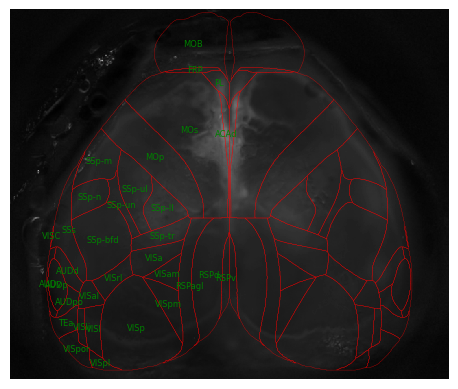

In [7]:
# plot warped avg_frame & CCF

fig = plt.figure()
plt.imshow(std_array[0, :, :], cmap='gray')  # 将 snr_array 替换为 std_array
# plt.imshow(brain_mask, cmap='gray')

for i, r in ccf_regions.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=6, alpha=1, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.show()



In [12]:
# don't delete

def plot_movie_heatmap(movie_data, path_outfile=None, title=None, vmin=None, vmax=None,
                          cmap='hot', pixel_um=None, patches=None, ccf_regions=None, ccf_color='w'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    if vmin is None:
        vmin = np.min(movie_data)
    if vmax is None:
        vmax = np.max(movie_data)


    img = plt.imshow(movie_data, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    if pixel_um is not None:
        # Calculate the length of the scale line in pixels
        scale_line_length = 1e3 / pixel_um
        line = plt.Line2D([0, 0 + scale_line_length], [movie_data.shape[1] - 4, movie_data.shape[1] - 4], color='white',
                            linewidth=2)
        plt.gca().add_line(line)
        plt.text(scale_line_length / 2, movie_data.shape[1] + 15, '1mm', color='black', fontsize=12, ha='center')
    if patches:
        # 调用plot_borders函数在当前轴上画边界
        plot_borders(patches, plotAxis=ax, title=None, zoom=1,
                        borderWidth=1, isColor=False, plotName=True, fontSize=8)
    if ccf_regions is not None:
        for idx, r in ccf_regions.iterrows():
            ax.plot(r['left_x'], r['left_y'], ccf_color, lw=0.2)
            ax.plot(r['right_x'], r['right_y'], ccf_color, lw=0.2)
            ax.text(r.left_center[0], r.left_center[1], r.acronym, color=ccf_color, va='center', fontsize=4, alpha=1, ha='center')

    ax.axis('off')

    plt.colorbar()
    if title:
        fig.suptitle(title, fontsize=24)
    fig.set_facecolor('white')
    # plt.tight_layout(h_pad=0.5, w_pad=0, rect=[0, 0, 1, 0.97])
    if path_outfile is not None:
        plt.savefig(path_outfile, bbox_inches='tight')
    plt.show()

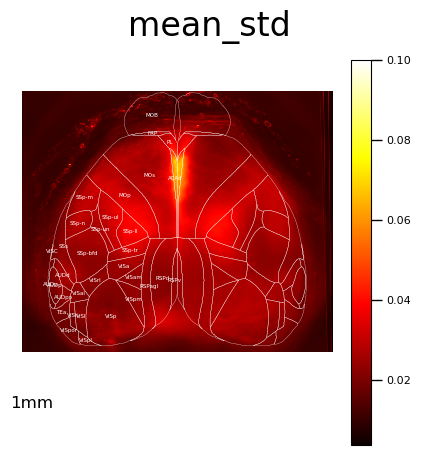

In [13]:

plot_movie_heatmap(std_array.mean(axis=0), path_outfile=pjoin(path_summary, 'mean_std.png'),
                      title='mean_std', vmax=0.1, pixel_um=26, patches=None,
                      ccf_regions=ccf_regions)



In [15]:
def flat_mask_warped(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,warped_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,warped_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(warped_height, warped_width))
    t = Uflat[idx,:]
    return t

std_array_flat= std_array.transpose(1,2,0).reshape(warped_height*warped_width, -1)
all_area_std =np.empty((33, std_array_flat.shape[-1]))

for area in range(1,34):
    all_area_std[area-1] = flat_mask_warped(std_array_flat, np.where(atlas == area)).mean(axis=0)
all_area_std = all_area_std.reshape(33, -1)

np.save(pjoin(path_summary, 'all_area_std.npy'), all_area_std)

/tmp/ipykernel_3935205/2967165201.py:18: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='std', data=df_long, order=None, scale='width', inner='quartile', color='grey')   # 绘制小提琴图


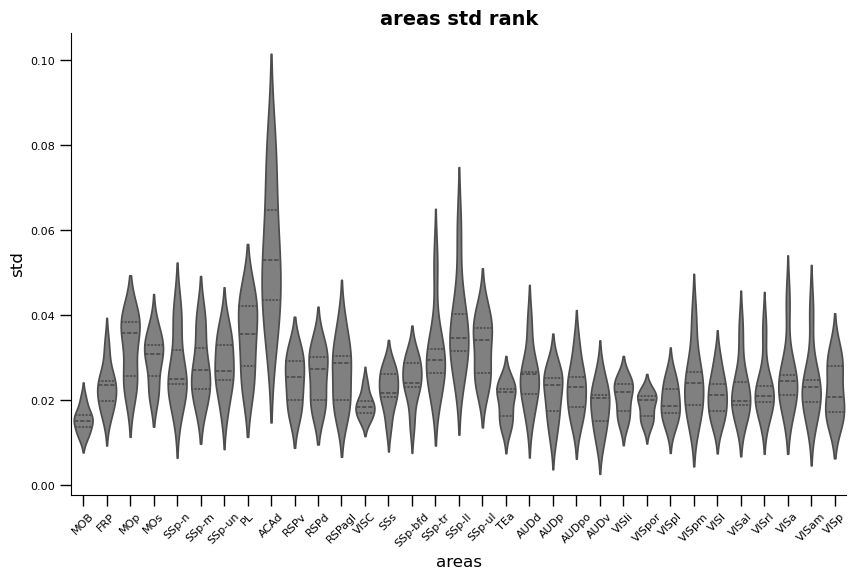

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 将矩阵转换为 DataFrame
df = pd.DataFrame(all_area_std.reshape(33, -1).T, columns=area_list)

# 将数据转换为长格式
df_long = df.melt(var_name='areas', value_name='std')

# 按每组的平均值对分组排序
group_order = df.mean(axis=0).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
# sns.boxplot(x='areas', y='std', data=df_long, order=group_order)
# sns.violinplot(x='areas', y='std', data=df_long, order=group_order, scale='width', inner='quartile')   # 绘制小提琴图
sns.violinplot(x='areas', y='std', data=df_long, order=None, scale='width', inner='quartile', color='grey')   # 绘制小提琴图
plt.title('areas std rank')
plt.xlabel('areas')
plt.ylabel('std')
plt.xticks(rotation=45)
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
# plt.savefig(pjoin(path_summary, 'all areas std rank.png'), facecolor='white', transparent=False)
plt.savefig(pjoin(path_summary, 'all areas std.png'), facecolor='white', transparent=False)
plt.show()


## summary area correlation

In [22]:
path_correlation_ls = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/*/baseline/process', '*-baseline--', '*all area correlation.npy'))
print(f'{len(path_correlation_ls)} all_area_correlation.npy\n\n'+'\n'.join(path_correlation_ls))


7 all_area_correlation.npy

/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/baseline/process/20241219-182248-baseline--/P41_20241219-182248_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/baseline/process/20250110-012034-baseline--/P41_20250110-012034_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/baseline/process/20250110-172138-baseline--/U26_20250110-172138_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/baseline/process/20250110-211518-baseline--/U27_20250110-211518_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/baseline/process/20250111-212711-baseline--/U26_20250111-212711_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/baseline/process/20250112-070053-baseline--/Q12_20250112-070053_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/baseline/process/20250112-021423-baseline--/U27_20250112-021423_all area correlation.npy


In [25]:
correlation_list = [np.load(path_correlation) for path_correlation in path_correlation_ls]
correlation_array = np.asarray(correlation_list)
print('correlation_array.shape', correlation_array.shape)

np.save(pjoin(path_summary,'all_area_correlation.npy'), correlation_array)

correlation_array.shape (7, 33, 33)


In [27]:
area_list1 = ['MOB','FRP','MOp','MOs','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSp-n','SSp-m','SSp-un','SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

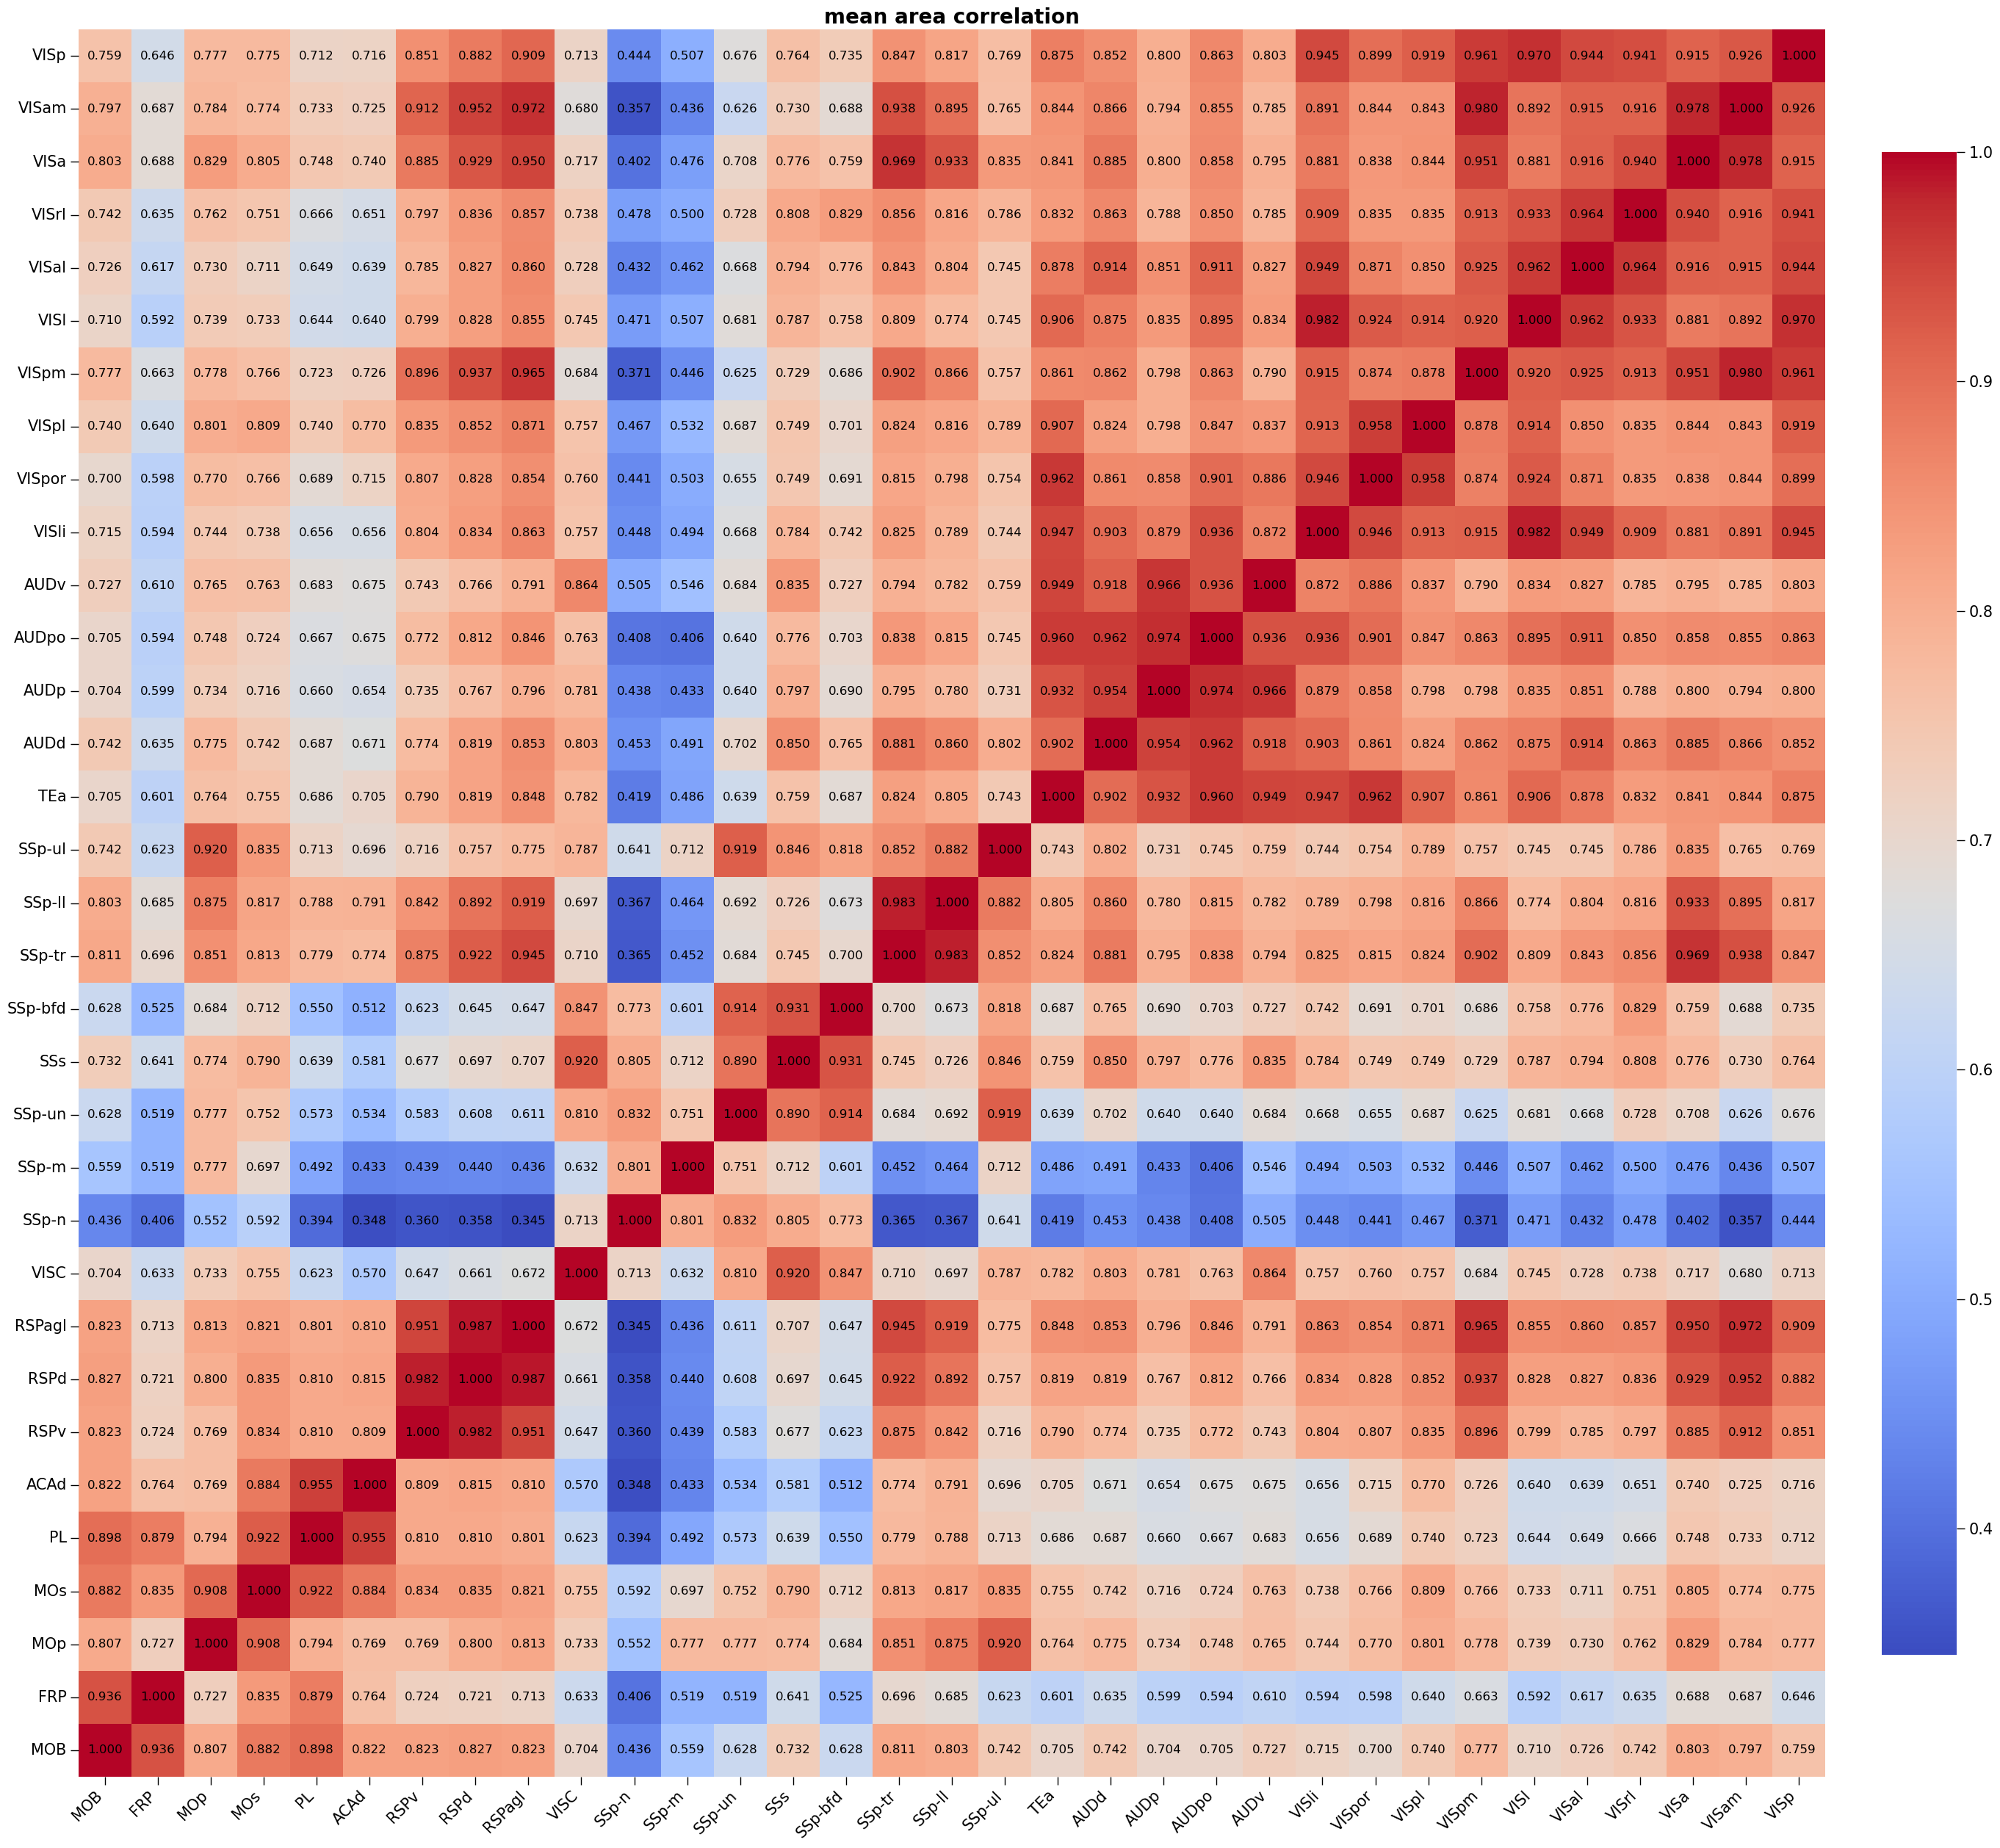

In [29]:
plot_heatmap(correlation_array.mean(axis=0), xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title='mean area correlation', 
             outfile=pjoin(path_summary,'mean area correlation.png'), dpi=300, annot=True)